In [75]:
# do the required imports
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
import numpy as np

#load the images into memory
(trainx, trainy), (testx, testy) = mnist.load_data()

In [76]:
print(trainx.shape)
print(trainy.shape)

(60000, 28, 28)
(60000,)


In [77]:
print(testx.shape)
print(testy.shape)

(10000, 28, 28)
(10000,)


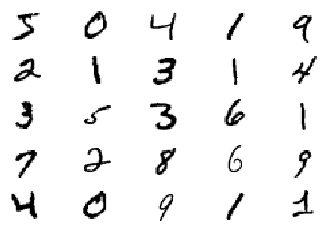

In [78]:
import matplotlib.pyplot as plt

for i in range(25):
    # define subplot
    plt.subplot(5, 5, 1+i)

    # turn off axis
    plt.axis('off')

    # plot raw pixel data
    plt.imshow(trainx[i], cmap='gray_r')

plt.show()

In [79]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, LeakyReLU, \
    Dropout, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.optimizers import Adam


# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(filters=64,
                     kernel_size=(3,3),
                     strides=(2,2),
                     padding='same',
                     input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    # second conv
    model.add(Conv2D(filters=64,
                     kernel_size=(3,3),
                     strides=(2,2),
                     padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(units=1, activation='sigmoid'))

    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt,
                  metrics=['accuracy'])
    return model

In [80]:
discriminator = define_discriminator()
discriminator.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 3136)            

In [81]:
# load and prepare mnist train images
def load_real_samples():
    # load the mnist data
    (trainx, _), (_,_) = mnist.load_data()

    # expand to 3d
    X = np.expand_dims(trainx, axis=-1)
    X = X.astype('float32') / 255.0

    return X

In [82]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances ids
    ix = np.random.randint(0, dataset.shape[0], n_samples)

    # retrieve selected images
    X = dataset[ix]

    # generate real class labesl
    y = np.ones((n_samples, 1))

    return X, y

In [83]:
# # generate fake samples (n_samples):
# def generate_fake_samples(n_samples):
#     X = np.random.rand(28*28*n_samples)
#     X = X.reshape((n_samples, 28, 28, 1))
#     y = np.zeros((n_samples, 1))
#
#     return X, y

In [84]:
# train the discriminator model
def train_discriminator(model: Model, dataset, n_iter=100, n_batch=256):
    half_batch = int(n_batch / 2)

    # manually enumerate
    for i in range(n_iter):
        # get randomly selected real samples
        xreal, yreal = generate_real_samples(dataset, half_batch)

        # update discriminator on real samples
        real_loss, real_acc = model.train_on_batch(xreal, yreal)

        # generate fake samples
        xfake, yfake = generate_fake_samples(half_batch)

        #update discriminator on fake samples
        fake_loss, fake_acc = model.train_on_batch(xfake, yfake)

        # summarise the performence
        print(f"{i+1} real={real_acc*100}% fake={fake_acc*100}")

In [85]:
# now do training
model = define_discriminator()

# load the image data
dataset = load_real_samples()

# fit the model
train_discriminator(model, dataset=dataset)

TypeError: generate_fake_samples() missing 2 required positional arguments: 'latent_dim' and 'n_samples'

In [ ]:
#define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()

    # foundation for 7x7 image
    n_nodes = 128*7*7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))

    #upsample to 14x14
    model.add(Conv2DTranspose(filters=128, kernel_size=(4,4),
                              strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))

    return model

In [ ]:
generator_sample = define_generator(100)
generator_sample.summary()

In [ ]:
# generate points in the latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)

    # reshape into batch of inputs for the net
    x_input = x_input.reshape(n_samples, latent_dim)

    return x_input

In [ ]:
# updated generate fake samples
def generate_fake_samples(g_model:Model, latent_dim, n_samples):

    # generate points in the latent space
    x_input = generate_latent_points(latent_dim, n_samples)

    #predic outputs
    X = g_model.predict(x_input)
    Y = np.zeros((n_samples, 1))

    return X, Y

In [86]:
latent_dim = 100
g_model = define_generator(latent_dim)
n_samples = 25

X, Y = generate_fake_samples(g_model, latent_dim, n_samples)

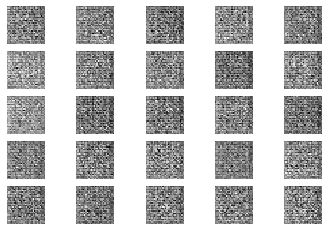

In [87]:
for i, sample in enumerate(X):
    plt.subplot(5,5,1+i)
    plt.axis('off')
    plt.imshow(sample.reshape(28,28), cmap='gray_r')
plt.show()

In [88]:
def define_gan(g_model:Model, d_model:Model):
    d_model.trainable = False

    # connect the model
    gan_model = Sequential()
    gan_model.add(g_model)
    gan_model.add(d_model)

    opt  = Adam(lr=0.0002, beta_1=0.5)
    gan_model.compile(loss='binary_crossentropy', optimizer=opt)
    return gan_model

In [89]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)

gan_model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_26 (Sequential)   (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_25 (Sequential)   (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


In [90]:
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n*n):
        # define subplot
        plt.subplot(n, n, 1+i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')

    # save plot to file
    filename = f"generated_plot_epoch{epoch+1}.png"
    plt.savefig(filename)
    plt.close()

In [91]:
def summarise_performance(epoch,
                          g_model:Model,
                          d_model:Model,
                          dataset:np.ndarray,
                          latent_dim,
                          n_samples=100):
    # get real samples
    xreal, yreal = generate_real_samples(dataset, n_samples)

    # evaluate discriminator on real samples
    loss_real, acc_real = d_model.evaluate(xreal, yreal)

    # prepare fake samples
    xfake, yfake = generate_fake_samples(g_model, latent_dim, n_samples)

    # eval discrimiantor on fake samples
    loss_fake, acc_fake = d_model.evaluate(xfake, yfake, verbose=0)

    # summarise discrimiantor performance
    print(f"Epoch={epoch+1} Discriminator Accuracy  "
          f"Real={acc_real*100} and "
          f"Fake={acc_fake*100}")

    # save the plot
    save_plot(xfake, epoch)

    # save the generaor model to file
    g_model.save(f"generator_model_epoch{epoch+1}.hdf5")

In [92]:
# train the generator and the discriminator
def train(g_model:Model,
          d_model:Model,
          gan_model:Model,
          dataset:np.ndarray,
          latent_dim: int,
          n_epochs=100,
          n_batch=256):

    # evaluate batch per epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)

    # calculate half-batch
    half_batch = int(n_batch / 2)

    # manually enumerate epochs
    for i in range(n_epochs):

        # enumerate bacthes over the trainign set
        for j in range(bat_per_epo):
            # get randomly selected real samples
            xreal, yreal = generate_real_samples(dataset, half_batch)

            # get fake examples
            xfake, yfake = generate_fake_samples(g_model, latent_dim, half_batch)

            # create the train set for the discriminator
            x, y = np.vstack((xreal, xfake), (yreal, yfake))

            # update discriminator model weights
            d_loss, d_acc = d_model.train_on_batch(x, y)

            # prepare points in the latent space as inputs for the generator
            xgan = generate_latent_points(latent_dim, n_batch)

            # create inverted labels for the fake samples
            ygan = np.ones((n_batch, 1))

            # update the generator via the discriminators error
            g_loss = gan_model.train_on_batch(xgan, ygan)

            # summarise the loss in this batch
            print(f"Train Epoch: {i+1}, {j+1}/{bat_per_epo} d={d_loss}, "
                  f"g={g_loss}")

        if i % 10 == 0:
            summarise_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model,d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)